# Call Center


Resource planning is the bread and butter of any sucessful business.

The following use-case is adopted from the [simmer mailing list](https://groups.google.com/g/simmer-devel/c/gsr6F7CJQf8/m/euW1ZaU0DAAJ)

Let's assume a customer service chat support, where the arrivals are requests from customers and the customer agents will have to respond to those messages. The process works as such: 

* The requests arrive throughout the day and are queued and pooled waiting for an available responder. 
* The responders are available in two shifts, excluding weekends; ideally the two shifts should not have individual queues, since there is already a pooled queue
* If a responder from Shift A is working on a request but is about to end their shift, they will turnover the request that they are working on to Shift B.
* Shifts A and B will have different capacities to mimight day/night shift regimes

Except for weekends, since there are no available shifts, so it will be worked on by the first available responder the following week.

Let's initialzie the environment by loading the latest version of kalasim


In [3]:
@file:Repository("*mavenLocal")

%useLatestDescriptors on
//%use kalasim(0.12-SNAPSHOT)
@file:DependsOn("com.github.holgerbrandl:kalasim:0.12-SNAPSHOT")
@file:DependsOn("com.github.holgerbrandl:kravis:0.9.95")

//%use kravis

Import required methods & classes

In [4]:
:classpath


Current classpath (65 paths):
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\lib-0.11.0-385.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\api-0.11.0-385.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\kotlin-script-runtime-1.8.20.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\kotlin-reflect-1.8.20.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\kotlin-stdlib-1.8.20.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\kotlin-stdlib-common-1.8.20.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\annotations-13.0.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\kotlinx-serialization-json-jvm-1.4.1.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\kotlinx-serialization-core-jvm-1.4.1.jar
C:\Users\brandl\Anaconda3\Lib\site-packages\run_kotlin_kernel\jars\kotlin-stdlib-jdk8-1.7.20.jar
C:\Users\bran

In [16]:
import kotlin.math.roundToInt
import kravis.GGPlot
import kravis.SessionPrefs
import kravis.device.SwingPlottingDevice
import org.kalasim.*
import org.kalasim.plot.kravis.display
import java.awt.Desktop
import java.awt.Dimension
import java.nio.file.Files
import java.time.Instant
import kotlin.math.max
import kotlin.time.Duration
import kotlin.time.Duration.Companion.days
import kotlin.time.Duration.Companion.hours
import kotlin.time.Duration.Companion.minutes
import kotlin.time.DurationUnit
import org.kalasim.plot.kravis.display

// Configure kravis for visualization because kernel detection seems buggy in jupyter-lib
kravis.SessionPrefs.OUTPUT_DEVICE = kravis.device.JupyterDevice() // bug in library, 



## Shift System

In particular choosing a shift model & shift capacity planning are key for many successful business operations. Because of complex dynamics and interplay, it's often very hard to work out the capacity and bottlenecks in such systems on paper.

Let's try to model the process described above using kalasim. First, we load the library and import the core functions with

**Note**: Notebook execution is currently blocked by https://github.com/Kotlin/kotlin-jupyter/issues/355

Next, we work out the model
* Shifts are modelled as enums
* The shift system is modelled using a [sequence builder](https://kotlinlang.org/docs/sequences.html)
* Requests are modelled as `Component` to add the it to the request queue
* The buisness process is modelled as component as well
* All entities are bound into a simulation of type `CallCenter` for easy experimentation

In [6]:

enum class ShiftID { A, B, WeekEnd }

val shiftModel = sequence {
    while(true) {
        repeat(5) { yield(ShiftID.A); yield(ShiftID.B) }
        yield(ShiftID.WeekEnd)
    }
}

Now we model the requests as simulation entities. Each request is modelled as component with a dedicated small lifecycle where the callcenter agent is [request](component.md#request)ed. The actual process time varies (exponentially distributed) around 2 minutes. 

In [28]:
class Request : Component() {
    val callCenter = get<Resource>()

    override fun process() = sequence {
        request(callCenter, capacityLimitMode = CapacityLimitMode.SCHEDULE) {
            // model requests with static duration for now once they got hold of an operator
//            hold(1.minutes)
            hold(exponential(30.minutes).sample())
        }
    }
}

Finally we need to model the call center manager to modulate the shift (or in simulation speak [resource](resources.md)) capacity dynamically.

In [29]:
class ShiftManager : Component() {
    val shiftIt = shiftModel.iterator()
    val callCenter = get<Resource>()

    override fun repeatedProcess() = sequence {
        val currentShift = shiftIt.next()

        log("starting new shift ${currentShift}")

        // adjust shift capacity at the beginning of the shift
        callCenter.capacity = when(currentShift) {
            ShiftID.A -> 2.0
            ShiftID.B -> 8.0
            ShiftID.WeekEnd -> 0.0
        }

        // wait for end of shift
        hold(if(currentShift == ShiftID.WeekEnd) 48.hours else 12.hours)
    }
}

Finally, we bring everything together in a simulation [environment](basics.md#simulation-environment). To allow for easy experimentation with different configuration and decision policies, we keep the shift manager abstract, forcing the simulationee to bring in a specific implementation to run an experiment.

In [30]:
abstract class CallCenter(val interArrivalRate: Duration = 10.minutes, logEvents: Boolean = false) :
    Environment(
        enableComponentLogger = logEvents,
        // note tick duration is just needed here to simplify visualization
        tickDurationUnit = DurationUnit.HOURS
    ) {

    // intentionally not defined at this point
    abstract val shiftManager: Component

    val callCenter = dependency { Resource("Call Center") }

    init {
        ComponentGenerator(iat = exponential(interArrivalRate)) { Request() }
    }
}

Let's run the unit for 1000 hours

In [31]:
val sim = object : CallCenter() {
    override val shiftManager = ShiftManager()
}

sim.run(30.days)

To understand the dynamics of the model we could now try inpspecting its progression. First we check out the queue length

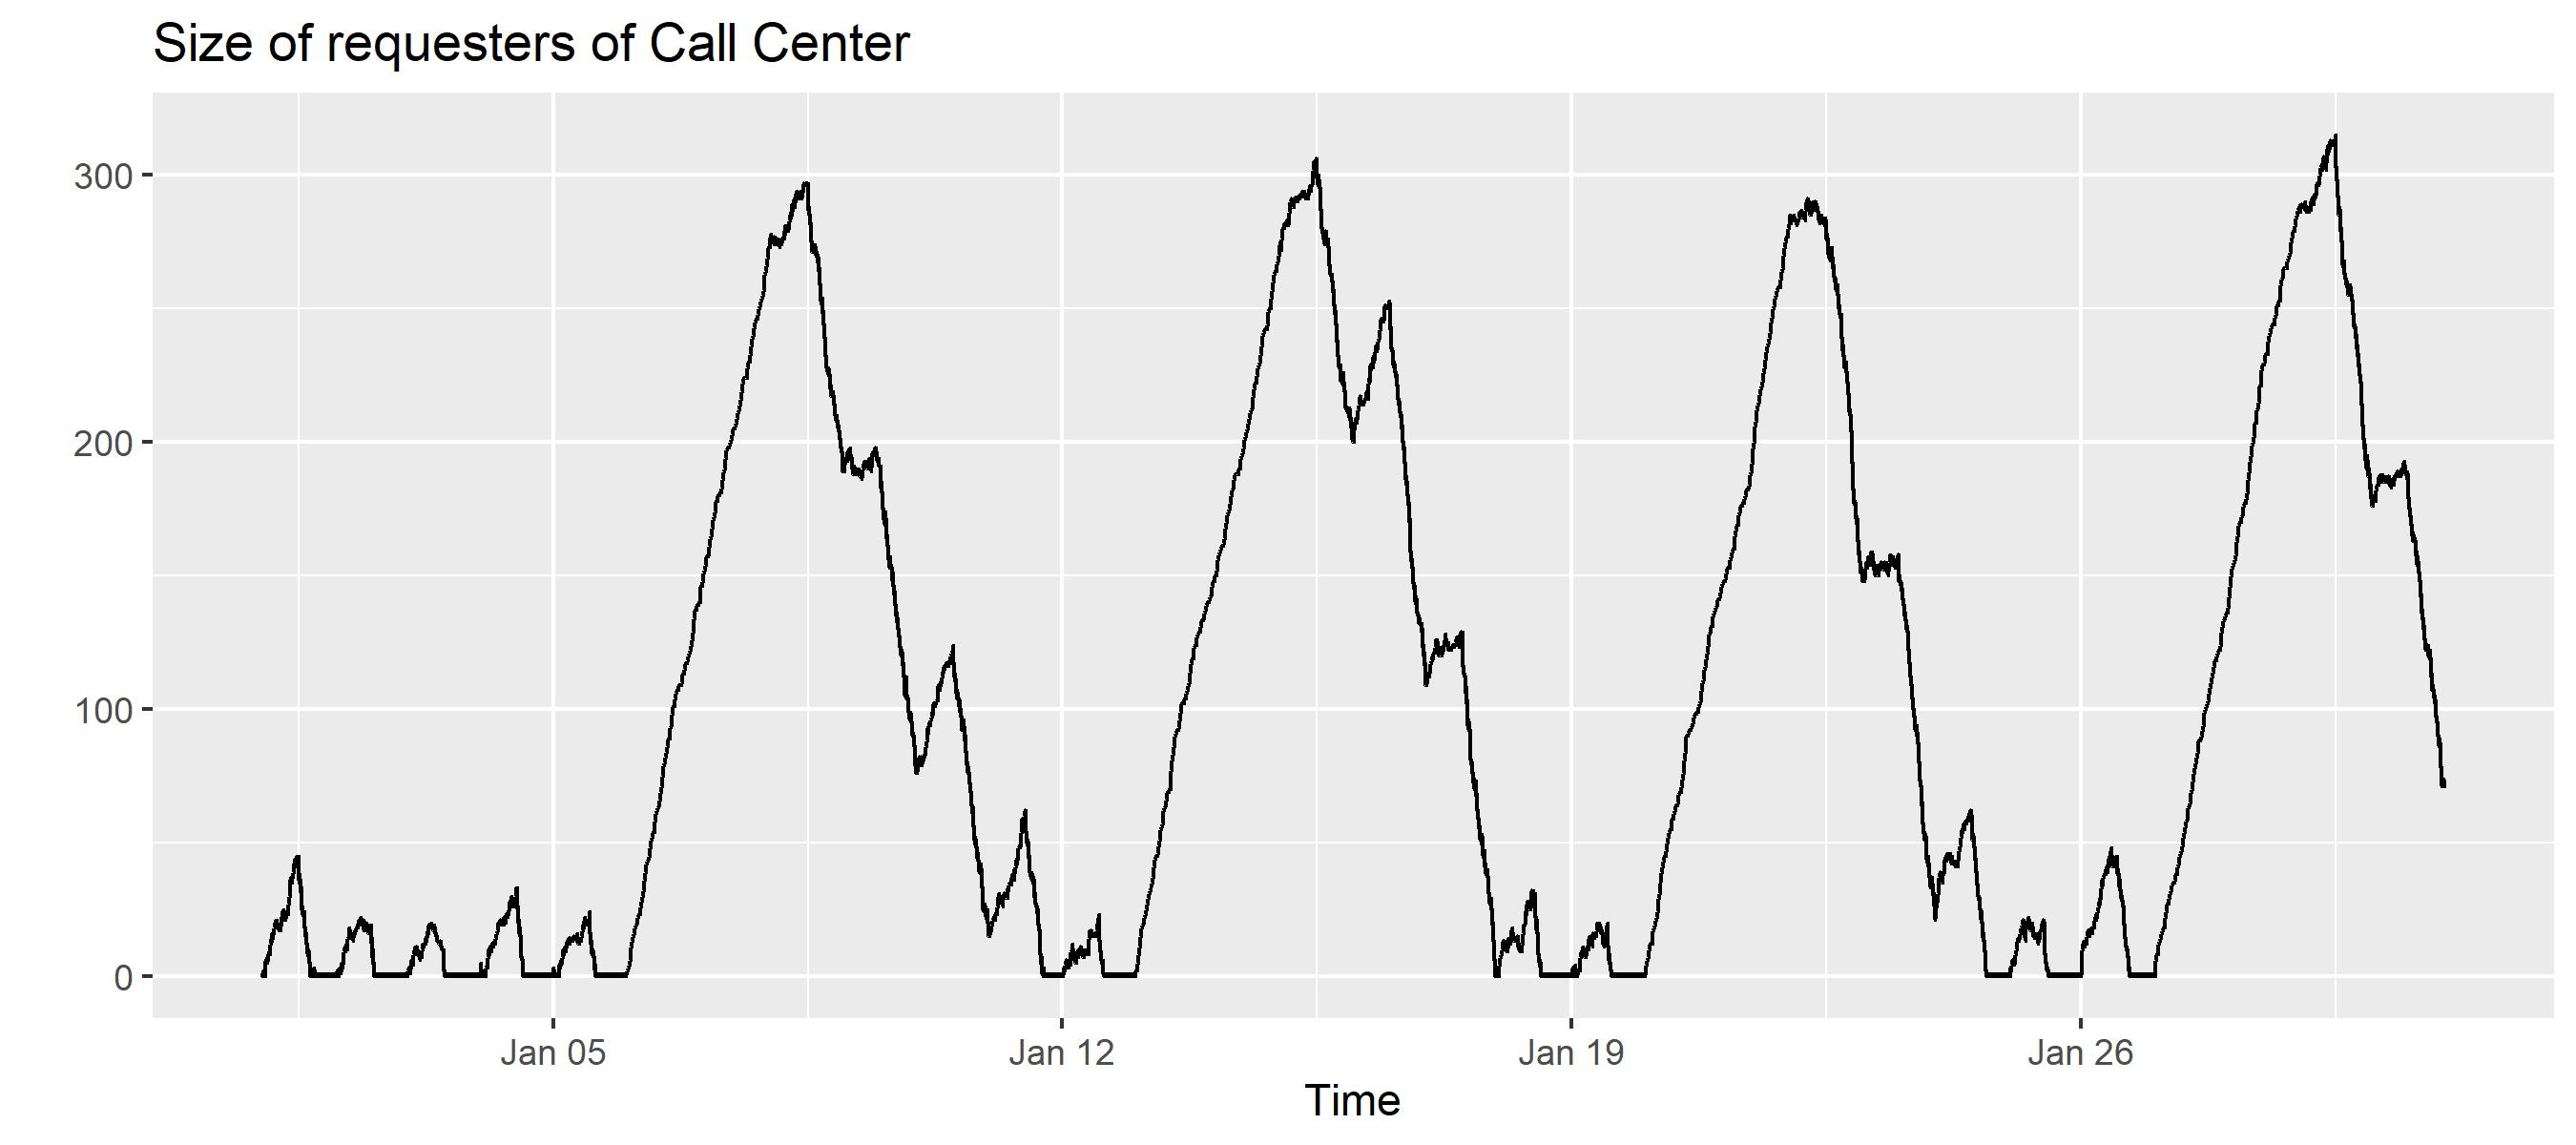

In [32]:
sim.callCenter.requesters.queueLengthTimeline.display()


## Shift Handover Precision

Clearly, this first version has the limitation, that tasks that overlap with a shift-change, do not immediately respect changes in capacity. That is, when changing from a shift with high to a shift with less capacity, ongoing tasks will be completed irrespective of the reduced capacity.

It's not straightforward to cancel these tasks to request them again in the next shift. This is because, a `release()` will - by design - check if new requests could be honored. So ongoing claims could be released easily, but requesting them again - even with higher priority - will cause them to be processed slightly after the immediatly honored request queue sucessors.

To solve the problem elegantly, we can use two other interactions namely `interrupt()` and `standby()`. With `interrupt()` we stop all ongoing tasks at a shift change. With `standby()` we can schedule process continauation in the next simulation cycle.

For the revised model we just need to model another `ShiftManager` with our revised hand-over process:

In [33]:
class InterruptingShiftManager : Component() {
    val shiftIt = shiftModel.iterator()
    val callCenter = get<Resource>()

    override fun repeatedProcess() = sequence {
        val currentShift = shiftIt.next()

        log("starting new shift $currentShift")

        // adjust shift capacity at the beginning of the shift
        callCenter.capacity = when(currentShift) {
            ShiftID.A -> 2.0
            ShiftID.B -> 8.0
            ShiftID.WeekEnd -> 0.0
        }

        // complete hangover calls from previous shift
        fun shiftLegacy() = callCenter.claimers.components.filter { it.isInterrupted }

        // incrementally resume interrupted tasks while respecting new capacity
        while(shiftLegacy().isNotEmpty() && callCenter.capacity > 0) {
            val numRunning = callCenter.claimers.components.count { it.isScheduled }
            val spareCapacity = max(0, callCenter.capacity.roundToInt() - numRunning)

            // resume interrupted tasks from last shift to max out new capacity
            shiftLegacy().take(spareCapacity).forEach { it.resume() }

            standby()
        }

        // wait for end of shift
        hold(if(currentShift == ShiftID.WeekEnd) 48.hours else 12.hours)

        // stop and reschedule the ongoing tasks
        callCenter.claimers.components.forEach {
            // detect remaining task time and request this with high prio so
            // that these tasks are picked up next in the upcoming shift
            it.interrupt()
        }
    }
}

We can now instantiate a new call center with the improved hand-over process

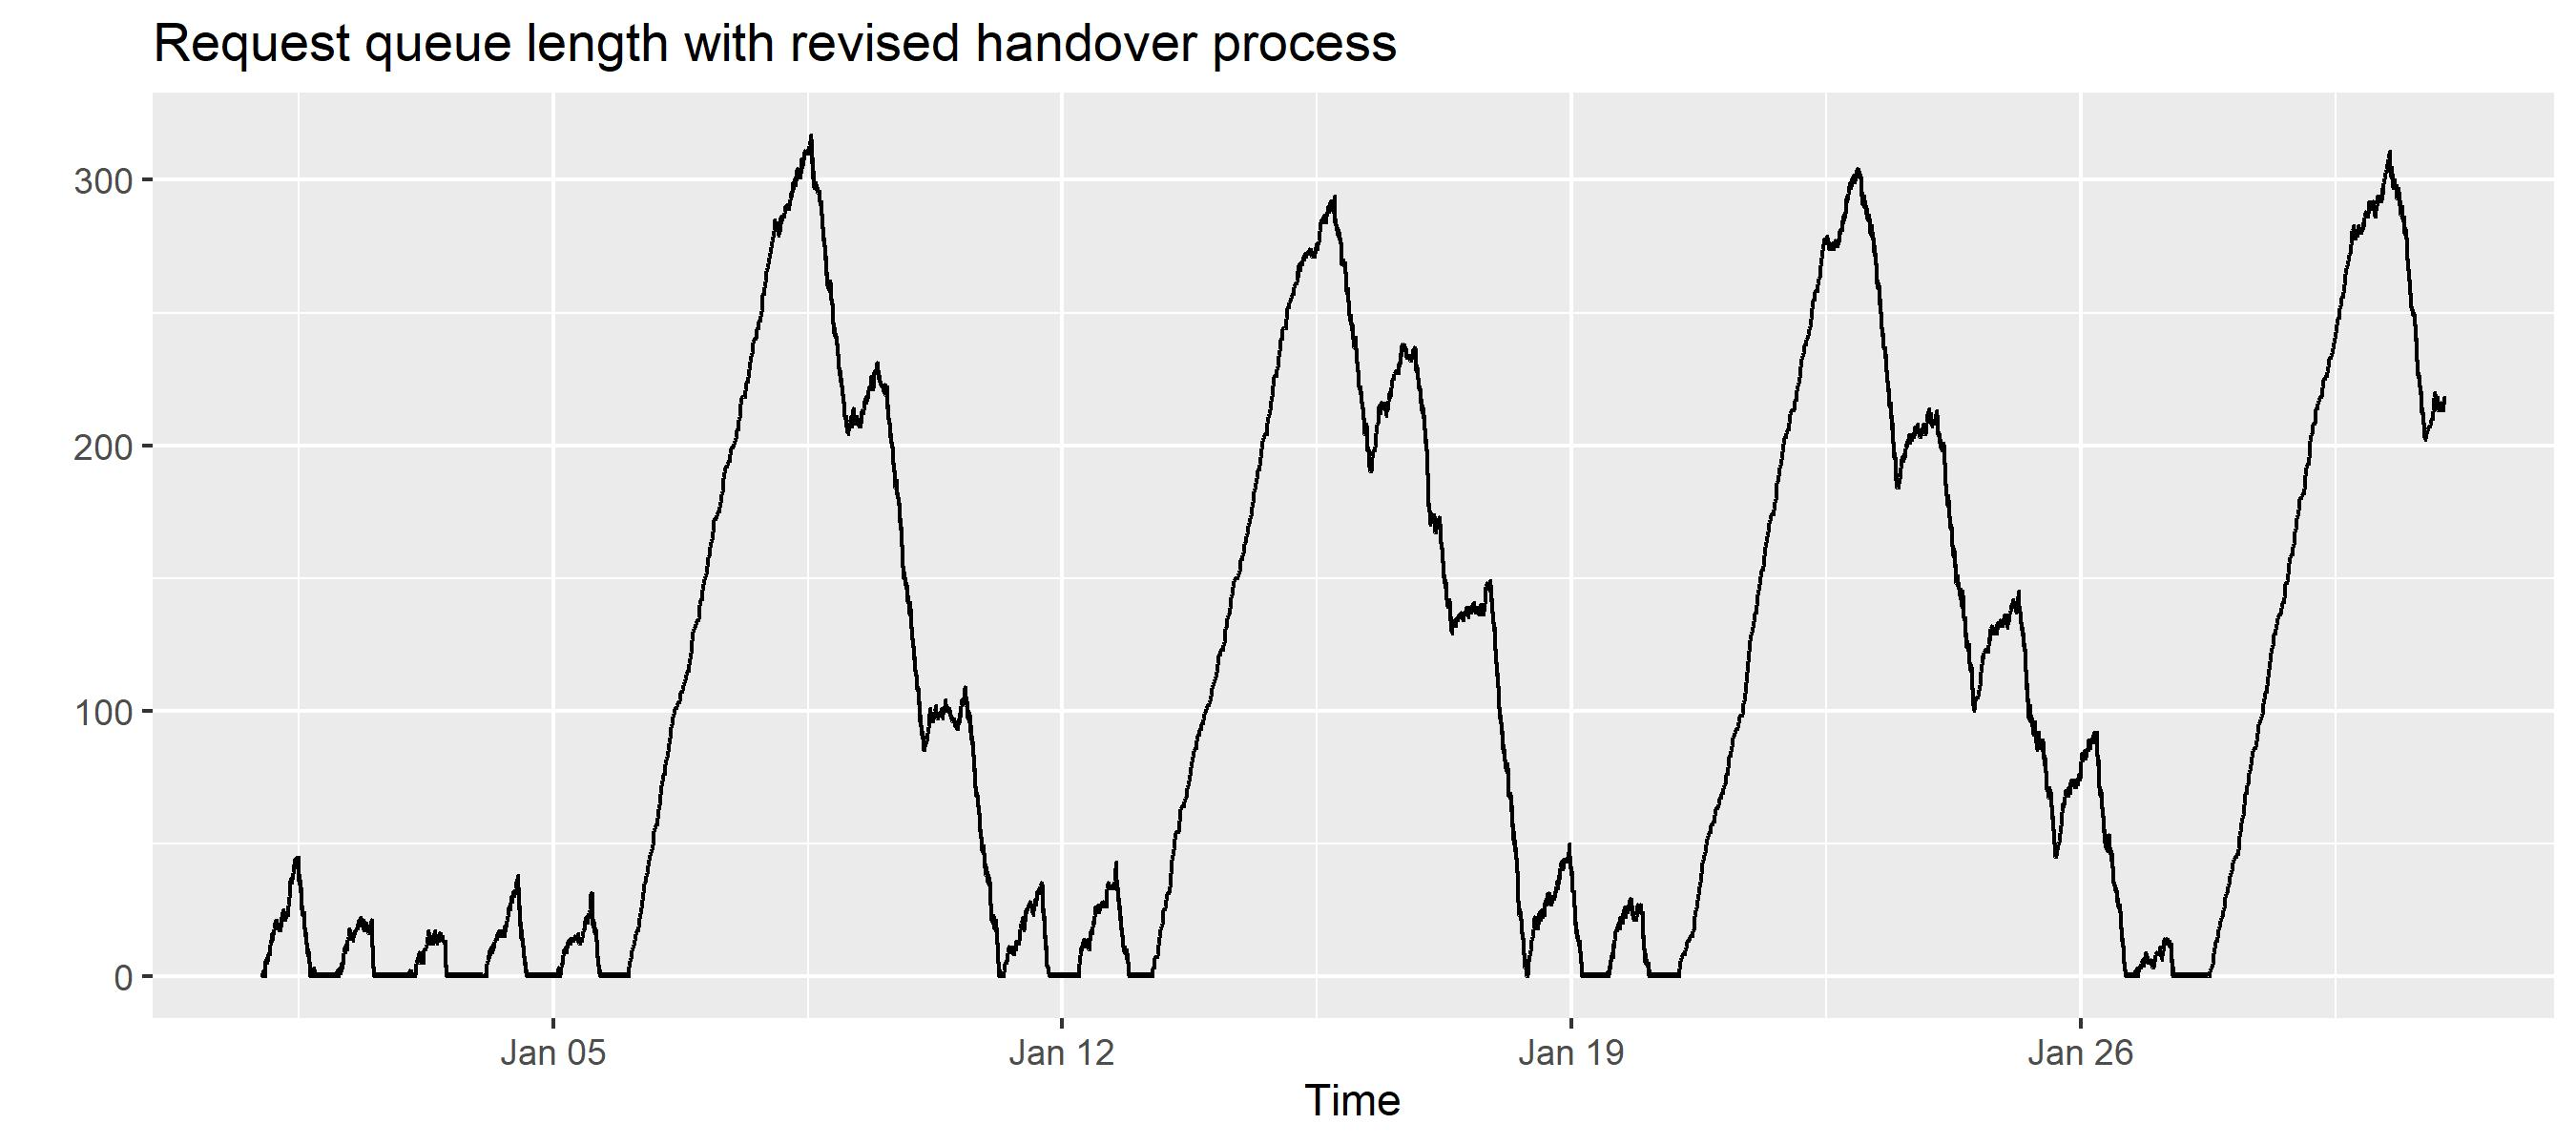

In [34]:
val intSim = object: CallCenter() {
    override val shiftManager = InterruptingShiftManager()
}
 
intSim.run(30.days)

intSim.callCenter.requesters.queueLengthTimeline
    .display("Request queue length with revised handover process")


Notably, this model has the almost the same dynamics, but is more correct during shift handover.